In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
train_path = './data/train_images_split/train'
val_path = './data/train_images_split/val'
test_path = './data/test_images'

In [4]:
X_train = []
x = 0
for folder in os.listdir(train_path):
    
    sub_path = train_path + '/' + folder
    
    for img in os.listdir(sub_path):
        image_path = sub_path + '/' + img
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (100,100))
        X_train.append(img_arr)
        x += 1
        print(x, end='\r')

In [5]:
X_test = []
x = 0
for img in os.listdir(test_path):
    
    image_path = test_path + '/' + img
    img_arr = cv2.imread(image_path)
    img_arr = cv2.resize(img_arr, (100,100))
    X_test.append(img_arr)
    x += 1
    print(x, end='\r')

In [6]:
X_val = []
x = 0
for folder in os.listdir(val_path):
    sub_path = val_path + '/' + folder
    
    for img in os.listdir(sub_path):
        image_path = sub_path + '/' + img
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (100,100))
        X_val.append(img_arr)
        x += 1
        print(x, end = '\r')

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (32,32),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (32,32),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (32,32),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 8323 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
Found 2084 images belonging to 10 classes.


In [10]:
y_train=training_set.classes
y_test=test_set.classes
y_val=val_set.classes

training_set.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [11]:
y_train.shape,y_test.shape,y_val.shape

((8323,), (0,), (2084,))

In [12]:
X_train.shape[1]

100

In [13]:
vgg = tf.keras.applications.VGG19(input_shape = (100, 100, 3), weights = 'imagenet', include_top = False)

In [14]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [15]:
x =  tf.keras.layers.Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction =  tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [16]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [84]:
# fit the model
history = model.fit(
  X_train,
  y_train,
  validation_data=(X_val,y_val),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
261/261 [==============================] - 610s 2s/step - loss: 1.6403 - accuracy: 0.4459 - val_loss: 1.4019 - val_accuracy: 0.5139
Epoch 2/10
261/261 [==============================] - 508s 2s/step - loss: 1.1929 - accuracy: 0.6239 - val_loss: 1.1611 - val_accuracy: 0.6425
Epoch 3/10
261/261 [==============================] - 652s 3s/step - loss: 1.0021 - accuracy: 0.6952 - val_loss: 1.0975 - val_accuracy: 0.6540
Epoch 4/10
207/261 [======================>.......] - ETA: 25:04 - loss: 0.8946 - accuracy: 0.7263

KeyboardInterrupt: 

Text(0.5, 1.0, 'Training and validation loss')

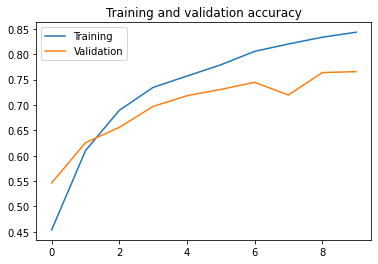

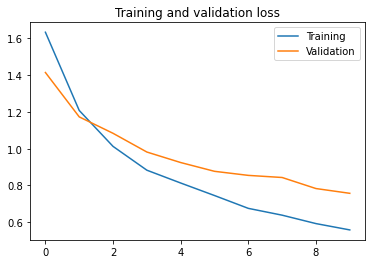

In [62]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [63]:
# save model
saved_model_path = "./paddy_model.h5"
model.save(saved_model_path)

In [64]:
# save sebagai tfjs
!tensorflowjs_converter --input_format=keras {saved_model_path} 

2022-05-17 21:15:36.183423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-17 21:15:36.183835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "C:\Users\hakhi\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\hakhi\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\hakhi\AppData\Local\Programs\Python\Python39\Scripts\tensorflowjs_converter.exe\__main__.py", line 7, in <module>
  File "C:\Users\hakhi\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\converter.py", line 813, in pip_main
    main([' '.join(sys.argv[1:])])
  File "C:\Users\hakhi\AppData\Local\

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model_tflite'

# YOUR CODE HERE
tf.saved_model.save(model,export_dir=export_dir)

In [ ]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model =  converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

# Test the Model with TFLite Interpreter 

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

lanjutin dari tensorflow2-public c2w1 assigment